<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/opt_flax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization using Flax


[Flax](https://colab.research.google.com/giathub/probml/pyprobml/blob/master/book1/mlp/flax_intro.ipynb) is a JAX library for creating deep neural networks. It also has a simple optimization library built in.
Below we show how to fit a multi-class logistic regression model using flax. 




In [ ]:
import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial
import os

import numpy as np
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [ ]:

import jax
import jax.numpy as jnp

from jax.scipy.special import logsumexp
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
print("jax version {}".format(jax.__version__))



jax version 0.2.7


## Import code

In [ ]:
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

In [ ]:
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax import optim

from jax.config import config
config.enable_omnistaging() # Linen requires enabling omnistaging

In [ ]:
# Book code
!git clone https://github.com/probml/pyprobml

Cloning into 'pyprobml'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 5880 (delta 99), reused 89 (delta 51), pack-reused 5715
Receiving objects: 100% (5880/5880), 200.88 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (3347/3347), done.
Checking out files: 100% (484/484), done.


In [ ]:


import pyprobml.scripts.fit_flax as ff

ff.test()

testing fit-flax
train step: 0, loss: 2.5385, accuracy: 0.00
train step: 1, loss: 2.3316, accuracy: 0.00
FrozenDict({
    Dense_0: {
        bias: DeviceArray([-0.07041515,  0.02852547,  0.02282   ,  0.02621041,
                      0.04047536,  0.0282678 ,  0.02441146,  0.0334954 ,
                     -0.16449487,  0.03070411], dtype=float32),
        kernel: DeviceArray([[-1.3670444e-01,  3.4958541e-02, -7.1266890e-03,
                       2.5135964e-02,  2.7813643e-02,  5.0281063e-03,
                       2.9270068e-02,  3.3206850e-02,  7.8319311e-03,
                      -1.9413888e-02],
                     [ 2.3842663e-02, -1.4299959e-02,  6.5577030e-04,
                      -6.1702281e-03, -1.8243194e-02, -3.5261810e-03,
                      -9.2503726e-03, -7.1800947e-03,  2.8626800e-02,
                       5.5447742e-03],
                     [ 1.2182933e-01, -1.1020064e-02,  6.6978633e-03,
                      -1.8483013e-02,  7.7033639e-03,  1.0741353e-03,
     

Now we show the source code for the fitting function in the file editor on the RHS.




In [ ]:
from google.colab import files
files.view('pyprobml/scripts/fit_flax.py')

<IPython.core.display.Javascript object>

## Data

We use the [tensorflow datasets](https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/intro/datasets.ipynb) library to make it easy to create minibatches.

We switch to the multi-class version of Iris.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

def get_datasets_iris():
  iris = sklearn.datasets.load_iris()
  X = iris["data"]
  y = iris["target"] 
  N, D = X.shape # 150, 4
  X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.33, random_state=42)
  train_data = {'X': X_train, 'y': y_train}
  test_data = {'X': X_test, 'y': y_test}
  return train_data, test_data

def load_dataset_iris(split, batch_size=None):
  train_ds, test_ds = get_datasets_iris()
  if split == tfds.Split.TRAIN:
    ds = tf.data.Dataset.from_tensor_slices({"X": train_ds["X"], "y": train_ds["y"]})
  elif split == tfds.Split.TEST:
    ds = tf.data.Dataset.from_tensor_slices({"X": test_ds["X"], "y": test_ds["y"]})
  if batch_size is not None:
    ds = ds.shuffle(buffer_size=batch_size)
    ds = ds.batch(batch_size)
  else:
    N = len(train_ds['X'])
    ds = ds.batch(N)
  ds = ds.prefetch(buffer_size=5)
  ds = ds.repeat() # make infinite stream of data
  return iter(tfds.as_numpy(ds)) # python iterator


batch_size = 30
train_ds = load_dataset_iris(tfds.Split.TRAIN, batch_size)
batch = next(train_ds)
print(batch['X'].shape)
print(batch['y'].shape)

test_ds = load_dataset_iris(tfds.Split.TEST, None) # load full test set
batch = next(test_ds)
print(batch['X'].shape)
print(batch['y'].shape)

(30, 4)
(30,)
(50, 4)
(50,)


## Model

In [ ]:
class Model(nn.Module):
  nhidden: int
  nclasses: int

  @nn.compact
  def __call__(self, x):
    if self.nhidden > 0:
      x = nn.Dense(self.nhidden)(x)
      x = nn.relu(x)
    x = nn.Dense(self.nclasses)(x)
    x = nn.log_softmax(x)
    return x

## Training loop


In [ ]:
from flax import optim

make_optimizer = optim.Momentum(learning_rate=0.1, beta=0.9)

model = Model(nhidden = 0, nclasses=3) # no hidden units ie logistic regression

batch_size = 100 # 30 # full batch training
train_ds = load_dataset_iris(tfds.Split.TRAIN, batch_size)
test_ds = load_dataset_iris(tfds.Split.TEST, batch_size)

rng = jax.random.PRNGKey(0)
num_steps = 200

  
params, history =  ff.fit_model(
    model, rng, num_steps, train_ds, test_ds, print_every=20)

display(history)

train step: 0, loss: 4.2830, accuracy: 0.35
train step: 20, loss: 0.9130, accuracy: 0.65
train step: 40, loss: 0.1380, accuracy: 0.96
train step: 60, loss: 0.1236, accuracy: 0.96
train step: 80, loss: 0.1094, accuracy: 0.98
train step: 100, loss: 0.1041, accuracy: 0.98
train step: 120, loss: 0.1002, accuracy: 0.98
train step: 140, loss: 0.0969, accuracy: 0.98
train step: 160, loss: 0.0942, accuracy: 0.99
train step: 180, loss: 0.0917, accuracy: 0.99


,train_loss,train_accuracy,test_loss,test_accuracy,step
0,4.2829556,0.35,1.8996174,0.28,0.0
1,0.9129939,0.65,0.2596313,0.82,20.0
2,0.13796234,0.96,0.11790658,0.96,40.0
3,0.123637825,0.96,0.086329155,1.0,60.0
4,0.109449916,0.97999996,0.089117624,1.0,80.0
5,0.10408671,0.97999996,0.08658601,1.0,100.0
6,0.10017303,0.97999996,0.08438768,1.0,120.0
7,0.09693686,0.97999996,0.0829268,0.97999996,140.0
8,0.094163276,0.98999995,0.081612006,0.97999996,160.0
9,0.091744594,0.98999995,0.08027973,0.97999996,180.0


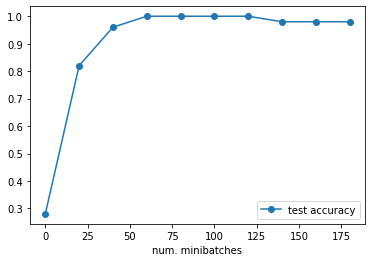

In [ ]:
plt.figure()
plt.plot(history['step'], history['test_accuracy'], 'o-', label='test accuracy')
plt.xlabel('num. minibatches')
plt.legend()
plt.show()

## Compare to sklearn


In [ ]:
train_ds, test_ds = get_datasets_iris()
from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
log_reg = LogisticRegression(solver="lbfgs", C=1e3, fit_intercept=True)
log_reg.fit(train_ds['X'], train_ds['y'])

w_sklearn = np.ravel(log_reg.coef_)
print(w_sklearn)
b_sklearn = np.ravel(log_reg.intercept_)
print(b_sklearn)

yprob_sklearn = log_reg.predict_proba(test_ds['X'])
print(yprob_sklearn.shape)
print(yprob_sklearn[:10,:])


ypred_sklearn = jnp.argmax(yprob_sklearn, axis=-1)
print(ypred_sklearn.shape)
print(ypred_sklearn[:10])

[5.69473 8.89993 -12.90385 -6.59589 -1.40077 1.88896 0.08464 -14.39687
 -4.29397 -10.78889 12.81921 20.99277]
[3.97582 32.52712 -36.50294]
(50, 3)
[[0.00000 1.00000 0.00000]
 [1.00000 0.00000 0.00000]
 [0.00000 0.00000 1.00000]
 [0.00000 0.99999 0.00000]
 [0.00001 0.99999 0.00000]
 [1.00000 0.00000 0.00000]
 [0.00605 0.99395 0.00000]
 [0.00000 0.00000 1.00000]
 [0.00000 0.98867 0.01133]
 [0.00006 0.99994 0.00000]]
(50,)
[1 0 2 1 1 0 1 2 1 1]


In [ ]:
# Flax version
print(params)

train_ds, test_ds = get_datasets_iris()
Xtest = test_ds['X']
logits = model.apply({'params': params}, Xtest)
yprob = nn.softmax(logits)
print(yprob.shape)
print(yprob[:10,:])
print(np.allclose(yprob_sklearn, yprob, atol=1e-0)) # very loose numerical tolerance

ypred = jnp.argmax(yprob, axis=-1)
print(ypred[:10])
print(np.allclose(ypred_sklearn, ypred))

FrozenDict({
    Dense_0: {
        bias: DeviceArray([0.67322, 1.05858, -1.73180], dtype=float32),
        kernel: DeviceArray([[1.13125, 0.95521, -2.30099],
                     [2.86528, -0.09720, -3.41202],
                     [-3.86220, -0.45856, 4.46158],
                     [-1.57317, -1.24467, 3.70615]], dtype=float32),
    },
})
(50, 3)
[[0.00057 0.94575 0.05368]
 [0.99750 0.00250 0.00000]
 [0.00000 0.00014 0.99986]
 [0.00131 0.91360 0.08509]
 [0.00045 0.97463 0.02493]
 [0.99551 0.00449 0.00000]
 [0.02960 0.96893 0.00147]
 [0.00008 0.27976 0.72016]
 [0.00012 0.66911 0.33077]
 [0.00644 0.98950 0.00406]]
True
[1 0 2 1 1 0 1 2 1 1]
True
